https://github.com/mickaellalande/PhD/blob/master/CICLAD/LMDZ_grid/grid_noro.ipynb

In [1]:
using PyCall
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")
xr = pyimport("xarray")

PyObject <module 'xarray' from '/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/__init__.py'>

In [2]:
relief = xr.open_dataset("/home/lalandmi/Dropbox/Thèse/notebooks/Relief.nc").RELIEF
relief

PyObject <xarray.DataArray 'RELIEF' (latitude: 1080, longitude: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167
  * latitude   (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

In [3]:
# Grille cible
# path = "/data/mlalande/ELC-144x142x79_clim"
path = "/home/lalandmi/Dropbox/data/ELC-144x142x79_clim"
limit = xr.open_dataset(path*"/Output/Boundary/ELC-144x142x79_clim_limit.nc")
grilles_gcm = xr.open_dataset(path*"/Output/Grid/ELC-144x142x79_grilles_gcm.nc")
start = xr.open_dataset(path*"/Output/Restart/ELC-144x142x79_clim_start.nc")
startphy = xr.open_dataset(path*"/Output/Restart/ELC-144x142x79_clim_startphy.nc")

# orog_fx_IPSL = xr.open_dataarray("/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc")
orog_fx_IPSL = xr.open_dataarray("/home/lalandmi/Dropbox/data/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc")
# cyclic = orog_fx_IPSL.isel(lon=slice(0,1)).copy()
# cyclic.lon.values = [360.0, ]
# orog_fx_IPSL_cyclic = xr.combine_nested([orog_fx_IPSL, cyclic], concat_dim="lon")

PyObject <xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 , 2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 2658.9578, 2668.209 , 2677.9058],
       [2618.7102, 2638.589 , 2658.8015, ..., 2562.443 , 2580.6404, 2599.4429],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

In [5]:
# Needs to be in radian
xd = np.deg2rad(relief.longitude)
yd = np.deg2rad(relief.latitude)
zd = relief.transpose()

# Radians? Yes I guess
# MODULE conf_dat_m does this actually before to call grid_noro in 
#   CALL conf_dat2d(orogvar, lon_ini, lat_ini, lon_rad, lat_rad, relief_hi,.FALSE.)
# Here I cheat because I already have this values in from the output start.nc
x = start.rlonv #np.deg2rad(orog_fx_IPSL_cyclic.lon-180)
y = start.rlatu #.sortby('lat', ascending=False)

imdp = xd.size
jmdp = yd.size

1080

In [6]:
imdp/10

216.0

In [7]:
iext = Int(imdp/10) #  To extend for computation
xpi = np.pi # Pi
rad = 6371229 # Rayon de la Terre en mètres
zdeltay = 2*xpi/jmdp*rad # 2 delta y en mètres (2 delta latitude -> pour calculer les slopes)
zdeltay

37066.307816181936

In [8]:
xd

PyObject <xarray.DataArray 'longitude' (longitude: 2160)>
array([-3.1401389, -3.1372292, -3.1343198, ...,  3.1343198,  3.1372292,
        3.1401389], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167

In [13]:
xusn = np.zeros(imdp+2*iext)
                
xusn[iext+1:imdp+iext] = xd.values
xusn[1:iext] = xd.values[imdp-iext+1:imdp] .- 2xpi
xusn[imdp+iext+1:imdp+2*iext] = xd.values[1:iext] .+ 2xpi
xusn

2592-element Vector{Float64}:
 -3.7684555689441126
 -3.765545908604757
 -3.762634817753927
 -3.7597253958331507
 -3.756824795399801
 -3.7539151350604456
 -3.7510057131396692
 -3.748094622288839
 -3.745185200368063
 -3.7422755400287073
 -3.739366118107931
 -3.736455027257101
 -3.733556095753805
  ⋮
  3.736455027257101
  3.739366118107931
  3.7422755400287073
  3.745185200368063
  3.748094622288839
  3.7510057131396692
  3.7539151350604456
  3.756824795399801
  3.7597253958331507
  3.762634817753927
  3.765545908604757
  3.7684555689441126

In [14]:
yusn = np.zeros(jmdp+2)
yusn[1] = (yd[1] + yd[1] - yd[2]).item(0)
yusn[2:jmdp+1] = yd.values
yusn[end] = yd[end]+(yd[end]-yd[end-1])
yusn

1082-element Vector{Float64}:
  1.5722498893737793
  1.5693398714065552
  1.566429853439331
  1.563519835472107
  1.560619831085205
  1.55771005153656
  1.5547999143600464
  1.5518897771835327
  1.5489801168441772
  1.5460699796676636
  1.54315984249115
  1.5402498245239258
  1.537339687347412
  ⋮
 -1.5402498245239258
 -1.54315984249115
 -1.5460699796676636
 -1.5489801168441772
 -1.5518897771835327
 -1.5547999143600464
 -1.55771005153656
 -1.560619831085205
 -1.563519835472107
 -1.566429853439331
 -1.5693398714065552
 -1.5722498893737793

In [15]:
# np.pad can simply things... and in the future xr.pad even better
zusn = np.ones((imdp+2*iext,jmdp+2))

zusn[iext+1:imdp+iext,2:jmdp+1] = zd.values

zusn[1:iext,2:jmdp+1] = zd.values[imdp-iext+1:imdp,:]
zusn[imdp+iext+1:imdp+2*iext,2:jmdp+1] = zd.values[1:iext,:]

zusn[:,1] = zusn[:,2]
zusn[:,end] = zusn[:,end-1]

zusn

2592×1082 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  2909.99  2889.88  2882.19  2882.19
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2909.33  2886.62  2878.18  2878.18
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2909.07  2881.52  2874.51  2874.51
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2909.86  2887.52  2879.06  2879.06
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2910.84  2891.28  2883.25  2883.25
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  2909.83  2890.61  2883.92  2883.92
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2907.86  2887.5   2883.41  2883.41
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2908.1   2892.44  2888.42  2888.42
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2911.01  2897.84  2894.0   2894.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2914.29  2901.15  2896.53  2896.53
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  2915.4   2900.31  2893.5   2893.5
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2913.31  2894.56  2883.67  2883.67
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2909.74  2885.6   2867.94  2867.94
 ⋮           

In [1]:
using Plots

In [20]:
function plot_matrix(my_matrix)
    n,m = collect(size(my_matrix)) .+ 1 .- 1e-10
    f(x,y) = my_matrix[Int(floor(x)), Int(floor(y))]
    Plots.Image(f, (1, m), (1, n))
end

plot_matrix (generic function with 1 method)

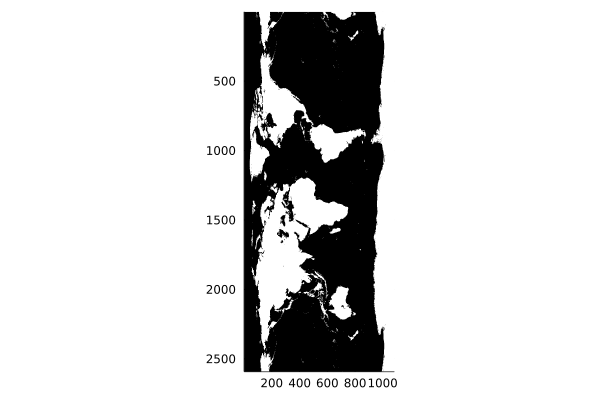

In [23]:
using Colors, Plots
plot(Gray.(zusn))

In [24]:
imar = orog_fx_IPSL.lon.size
imar

144

In [25]:
jmar = orog_fx_IPSL.lat.size
jmar

143

In [36]:
#   ALLOCATE(a(imar+1),b(imar+1))
a = np.zeros(imar+1)
b = np.zeros(imar+1)

#   b(1:imar)=(x(1:imar  )+ x(2:imar+1))/2.0
b[1:imar] = (x.values[1:imar] + x.values[2:imar+1])/2
# #   b(imar+1)= x(  imar+1)+(x(  imar+1)-x(imar))/2.0
b[imar+1] = x.values[imar+1] + (x.values[imar+1]-x.values[imar])/2.0

# #   a(1)=x(1)-(x(2)-x(1))/2.0
a[1] = x.values[1] - (x.values[2]-x.values[1])/2.0
# #   a(2:imar+1)= b(1:imar)
a[2:imar+1] = b[1:imar]

144-element Vector{Float64}:
 -3.119776037939864
 -3.076142806640006
 -3.0325095753401476
 -2.9888763440402895
 -2.9452431127404313
 -2.901609881440573
 -2.857976650140715
 -2.8143434188408563
 -2.770710187540998
 -2.72707695624114
 -2.6834437249412817
 -2.6398104936414235
 -2.5961772623415653
  ⋮
  2.639810493641423
  2.6834437249412812
  2.7270769562411394
  2.770710187540998
  2.8143434188408563
  2.8579766501407144
  2.9016098814405726
  2.945243112740431
  2.988876344040289
  3.032509575340147
  3.0761428066400054
  3.1197760379398636

In [37]:
d = np.zeros(jmar)
c = np.zeros(jmar)

# d et c opposite ?
#   d(1:jmar-1)=(y(1:jmar-1)+ y(2:jmar))/2.0
d[1:jmar-1] = (y.values[1:jmar-1] + y.values[2:jmar])/2
#   d(  jmar  )= y(  jmar  )+(y(  jmar)-y(jmar-1))/2.0
d[jmar] = y.values[jmar] + (y.values[jmar]-y.values[jmar-1])/2.0
#   c(1)=y(1)-(y(2)-y(1))/2.0
c[1] = y.values[1] - (y.values[2]-y.values[1])/2.0
#   c(2:jmar)=d(1:jmar-1)
c[2:jmar] = d[1:jmar-1]

142-element Vector{Float64}:
  1.5597343808315522
  1.5376104889048636
  1.515486596978175
  1.4933627050514862
  1.4712388131247973
  1.4491149211981087
  1.42699102927142
  1.4048671373447315
  1.3827432454180428
  1.3606193534913542
  1.3384954615646654
  1.3163715696379765
  1.294247677711288
  ⋮
 -1.3163715696379765
 -1.3384954615646654
 -1.3606193534913542
 -1.3827432454180428
 -1.4048671373447315
 -1.42699102927142
 -1.4491149211981087
 -1.4712388131247975
 -1.4933627050514862
 -1.5154865969781748
 -1.5376104889048636
 -1.5597343808315522

In [38]:
zphi = np.zeros((imar+1,jmar))     # GEOPOTENTIAL           (imar+1,jmar)
zmea = np.zeros((imar+1,jmar))     # MEAN OROGRAPHY         (imar+1,jmar)
zstd = np.zeros((imar+1,jmar))     # STANDARD DEVIATION     (imar+1,jmar)
zsig = np.zeros((imar+1,jmar))     # SLOPE                  (imar+1,jmar)
zgam = np.zeros((imar+1,jmar))     # ANISOTROPY             (imar+1,jmar)
zthe = np.zeros((imar+1,jmar))     # SMALL AXIS ORIENTATION (imar+1,jmar)
zpic = np.zeros((imar+1,jmar))     # MAXIMUM ALTITITUDE     (imar+1,jmar)
zval = np.zeros((imar+1,jmar))     # MINIMUM ALTITITUDE     (imar+1,jmar)
mask = np.zeros((imar+1,jmar))     # MASK   

145×143 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [40]:
weight = np.zeros((imar+1,jmar))
zxtzx  = np.zeros((imar+1,jmar))
zytzy  = np.zeros((imar+1,jmar))
zxtzy  = np.zeros((imar+1,jmar))
ztz    = np.zeros((imar+1,jmar))
zmea[:,:]   .= 0.0
zpic[:,:]   .=-1.E+10
zval[:,:]   .= 1.E+10

145×143 view(::Matrix{Float64}, :, :) with eltype Float64:
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10  …  1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10  …  1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10  …  1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10     1.0e10  1.0e10  1.0e10  1.0e10
 1.0e10  1.0e10  1.0e10  1.0e10  1.0e10  

## COMPUTE SLOPES CORRELATIONS ON USN GRID


In [49]:
@time begin
    zytzyusn = np.zeros((imdp+2*iext,jmdp+2))
    zxtzxusn = np.zeros((imdp+2*iext,jmdp+2))
    zxtzyusn = np.zeros((imdp+2*iext,jmdp+2))

    for j in 2:jmdp+1
        zdeltax = 2*np.pi*rad/imdp*np.cos(yusn[j])
        for i in 2:imdp+2*iext-1
            zytzyusn[i,j] = (zusn[i,j+1]-zusn[i,j-1])^2/zdeltay^2
            zxtzxusn[i,j] = (zusn[i+1,j]-zusn[i-1,j])^2/zdeltax^2
            zxtzyusn[i,j] = (zusn[i,j+1]-zusn[i,j-1])/zdeltay*(zusn[i+1,j]-zusn[i-1,j])/zdeltax
        end
    end
end

  1.930645 seconds (80.94 M allocations: 1.311 GiB, 11.70% gc time)


## SUMMATION OVER GRIDPOINT AREA


In [55]:
for i in 1:imar
    println(string(i)*"/144")
end

1/144
2/144
3/144
4/144
5/144
6/144
7/144
8/144
9/144
10/144
11/144
12/144
13/144
14/144
15/144
16/144
17/144
18/144
19/144
20/144
21/144
22/144
23/144
24/144
25/144
26/144
27/144
28/144
29/144
30/144
31/144
32/144
33/144
34/144
35/144
36/144
37/144
38/144
39/144
40/144
41/144
42/144
43/144
44/144
45/144
46/144
47/144
48/144
49/144
50/144
51/144
52/144
53/144
54/144
55/144
56/144
57/144
58/144
59/144
60/144
61/144
62/144
63/144
64/144
65/144
66/144
67/144
68/144
69/144
70/144
71/144
72/144
73/144
74/144
75/144
76/144
77/144
78/144
79/144
80/144
81/144
82/144
83/144
84/144
85/144
86/144
87/144
88/144
89/144
90/144
91/144
92/144
93/144
94/144
95/144
96/144
97/144
98/144
99/144
100/144
101/144
102/144
103/144
104/144
105/144
106/144
107/144
108/144
109/144
110/144
111/144
112/144
113/144
114/144
115/144
116/144
117/144
118/144
119/144
120/144
121/144
122/144
123/144
124/144
125/144
126/144
127/144
128/144
129/144
130/144
131/144
132/144
133/144
134/144
135/144
136/144
137/144
138/144
139/

In [58]:
zleny = xpi/jmdp*rad
zleny

18533.153908090968

In [59]:
xincr = xpi/jmdp/2
xincr

0.001454441043328608

In [61]:
num_tot = np.zeros((imar+1,jmar)) 
num_lan = np.zeros((imar+1,jmar))
num_lan

145×143 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [62]:
min(1, 2)

1

In [64]:
if 1 != 0
end

In [70]:
@time begin
    for ii in 1:imar+1
        println(string(ii)*"/144")
        for jj in 1:jmar
            # println(string(ii)*"/143")  
            for j in 2:jmdp+1

                zlenx = zleny*cos(yusn[j]) # à changer -> pas carré !
                weighy = (xincr+min(c[jj]-yusn[j], yusn[j]-d[jj]))*rad
                weighy = max(0., min(weighy,zleny))  

                if weighy != 0
                    for i in 2:imdp+2*iext-1
                        weighx = (xincr+min(xusn[i]-a[ii], b[ii]-xusn[i]))*rad*cos(yusn[j])
                        weighx = max(0., min(weighx,zlenx))

                        if weighx != 0
                            num_tot[ii,jj] = num_tot[ii,jj] + 1.0
                            if zusn[i,j] >= 1. 
                                num_lan[ii,jj] = num_lan[ii,jj] + 1.0
                            end
                            weight[ii,jj] = weight[ii,jj] + weighx*weighy
                            zmea[ii,jj] =  zmea[ii,jj] + zusn[i,j]*weighx*weighy # MEAN
                            zpic[ii,jj] = max(zpic[ii,jj], zusn[i,j])         # PEAKS
                            zval[ii,jj] = max(zval[ii,jj], zusn[i,j])         # VALLEYS

                        end
                    end
                end
            end
        end
    end
end

1/144
2/144
3/144
4/144
5/144
6/144
7/144
8/144
9/144
10/144
11/144
12/144
13/144
14/144
15/144
16/144
17/144
18/144
19/144
20/144
21/144
22/144
23/144
24/144
25/144
26/144
27/144
28/144
29/144
30/144
31/144
32/144
33/144
34/144
35/144
36/144
37/144
38/144
39/144
40/144
41/144
42/144
43/144
44/144
45/144
46/144
47/144
48/144
49/144
50/144
51/144
52/144
53/144
54/144
55/144
56/144
57/144
58/144
59/144
60/144
61/144
62/144
63/144
64/144
65/144
66/144
67/144
68/144
69/144
70/144
71/144
72/144
73/144
74/144
75/144
76/144
77/144
78/144
79/144
80/144
81/144
82/144
83/144
84/144
85/144
86/144
87/144
88/144
89/144
90/144
91/144
92/144
93/144
94/144
95/144
96/144
97/144
98/144
99/144
100/144
101/144
102/144
103/144
104/144
105/144
106/144
107/144
108/144
109/144
110/144
111/144
112/144
113/144
114/144
115/144
116/144
117/144
118/144
119/144
120/144
121/144
122/144
123/144
124/144
125/144
126/144
127/144
128/144
129/144
130/144
131/144
132/144
133/144
134/144
135/144
136/144
137/144
138/144
139/

LoadError: syntax: unexpected "end"

In [71]:
zmea

145×143 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.51829e13  7.83222e12  9.63101e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.50097e13  7.82164e12  9.57428e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.48279e13  7.82074e12  9.50666e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.46383e13  7.8127e12   9.49934e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.44599e13  7.80172e12  9.4897e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.43245e13  7.79195e12  9.48639e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.42114e13  7.77642e12  9.47465e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     9.38093e12  5.17188e12  6.3117e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     9.23821e12  5.16058e12  6.30636e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     9.03895e12  5.14641e12  6.29609e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  8.83793e12  5.12896e12  6.29605e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     8.67775e12  5.113e12    6.29069e11
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     8.58962e12  5.0965e12   6.27365e11
 ⋮             